# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [187]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [188]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
17710,25340,70292,NaN,25-03-2020,Supermarket #purchaselimits mean people have t...,Negative
19894,28047,72999,Cheltenham uk,26-03-2020,just got this email from Ocado been with them ...,Positive
8987,14711,59663,BIAFRA LAND,20-03-2020,#Coronavirus: Asian Woman Kicked Out Of Ghanai...,Positive
3316,7816,52768,NaN,18-03-2020,"This corona season, stop and think about the e...",Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [189]:
# -- YOUR CODE HERE --

df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [190]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0)

Сбалансированы ли классы?

In [191]:
# -- YOUR CODE HERE --
df['Sentiment'].value_counts()

,count
Sentiment,
1,18046
0,15398


In [192]:
pos = df['Sentiment'].value_counts()[1]
neg = df['Sentiment'].value_counts()[0]

print(f'Положительная окраска: {round(((pos / (pos + neg)) * 100), 2)} %')
print(f'Отрицательная окраска: {round(((neg / (pos + neg)) * 100), 2)} %')

Положительная окраска: 53.96 %
Отрицательная окраска: 46.04 %


**Ответ:** Можем сказать, что классы практически сбалансированны, так как нет сильного преобладания какого-либо класса

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [193]:
# -- YOUR CODE HERE --
df.isna().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


In [194]:
df['Location'] = df['Location'].fillna('Unknown')

In [195]:
df.isna().sum() #проверим, что пропусков теперь нет

,0
UserName,0
ScreenName,0
Location,0
TweetAt,0
OriginalTweet,0
Sentiment,0


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [196]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)
# -- YOUR CODE HERE --

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [197]:
# -- YOUR CODE HERE --

tokens = dict()

for t in train['OriginalTweet']:
  toks = t.lower().split()
  for tok in toks:
    if tok not in tokens:
      tokens[tok] = 1
    else:
      tokens[tok] += 1

Какой размер словаря получился?

In [198]:
# -- YOUR CODE HERE --
len(tokens)

79755

В словаре 79755 токенов

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [199]:
# -- YOUR CODE HERE --
poptok = sorted(tokens.items(), key=lambda x: x[1], reverse=True)[:10]

print('10 самых популярных токенов:')
for tok, n in poptok:
  print(f'{tok}: {n}')

10 самых популярных токенов:
the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:**

`#coronavirus` является популярным токеном, потому что указывает на тематику нашего датасета, и хэштеги часто используются в твиттах

все остальные токены являются самыми популярными, так как они являются служебными частами речи и часто встречаются в любом тексте на английском языке.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [200]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

# -- YOUR CODE HERE --

noise = stopwords.words('english')
filt_tokens = {k: v for k, v in tokens.items() if k not in noise}

In [201]:
popfilttok = sorted(filt_tokens.items(), key=lambda x: x[1], reverse=True)[:10]

print('10 самых популярных токенов:')
for tok, n in popfilttok:
  print(f'{tok}: {n}')

10 самых популярных токенов:
#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Ответ:**  
Теперь самыми популярными стали слова, напрямую связанные с тематикой датасета (пандемией): преобладают слова, связанные с последствиями пандемии (цены, продовольствие и так далее), однако встречается 1 несловесный символ

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [202]:
# -- YOUR CODE HERE --
popfilttok = sorted(filt_tokens.items(), key=lambda x: x[1])[:20]

print('20 самых непопулярных токенов:')
for tok, n in popfilttok:
  print(f'{tok}: {n}')

20 самых непопулярных токенов:
https://t.co/1m881cwfuv: 1
happy..: 1
https://t.co/z0intks34x: 1
mnuchinãâs: 1
brink.: 1
https://t.co/jmobv8z0u0: 1
university's: 1
teaching.): 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@@ballardspahrll: 1
#aca: 1
easier...take: 1
ãânecessaryãâ: 1
https://t.co/0fmsmlgepm: 1
husted:: 1
irishman: 1
#happystpatricksday!: 1


**Ответ:**
Эти токены непопулярны, так как содержат
* уникальные ссылки
* юзернеймы пользователей
* слова, к которым "прилипли" знаки препинания ввиду особенностей токенизации с пощью `split`
* хештеги и слова, не связанные с тематикой датасета

Нужно поработать с этими токенами и очистить их от знаков пунктуации


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [203]:
from nltk.tokenize import TweetTokenizer

# -- YOUR CODE HERE --


tw = TweetTokenizer()

twtokens = dict()

for t in train['OriginalTweet']:
  toks = tw.tokenize(t.lower())
  for tok in toks:
    if tok not in twtokens:
      twtokens[tok] = 1
    else:
      twtokens[tok] += 1

In [204]:
poptwtok = sorted(twtokens.items(), key=lambda x: x[1], reverse=True)[:10]

print('10 самых популярных токенов:')
for tok, n in poptwtok:
  print(f'{tok}: {n}')

10 самых популярных токенов:
the: 26993
.: 24118
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:**
Теперь в топе токенов появились знаки пунктуации, которых раньше не было. Это связано с тем, что раньше мы разделяли текст по пробелам (соответственно, знаки препинания "примыкали" к словам), а теперь токенайзер разделяет знаки препинания в отдельные токены.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [205]:
from string import punctuation

# -- YOUR CODE HERE --
noise = stopwords.words('english')
filt_twtokens = {k: v for k, v in twtokens.items() if k not in noise
                 and k not in punctuation}
popfilttwtok = sorted(filt_twtokens.items(), key=lambda x: x[1], reverse=True)[:10]

print('10 самых популярных токенов:')
for tok, n in popfilttwtok:
  print(f'{tok}: {n}')

10 самых популярных токенов:
#coronavirus: 8808
â: 7415
: 7311
19: 7167
covid: 6253
prices: 4601
: 4372
food: 4367
store: 3877
supermarket: 3805


**Ответ:** Теперь появились токены, не похожие на слова: они содержат отдельные символы

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [206]:
# -- YOUR CODE HERE --
filt_twtokens1 = {k: v for k, v in filt_twtokens.items()
  if not (len(k) == 1 and ord(k) >= 128)}

In [207]:
popfilttwtok1 = sorted(filt_twtokens1.items(), key=lambda x: x[1], reverse=True)[:10]

print('10 самых популярных токенов:')
for tok, n in popfilttwtok1:
  print(f'{tok}: {n}')

10 самых популярных токенов:
#coronavirus: 8808
19: 7167
covid: 6253
prices: 4601
food: 4367
store: 3877
supermarket: 3805
grocery: 3523
people: 3463
#covid19: 2589


In [208]:
popfilttwtok2 = sorted(filt_twtokens1.items(), key=lambda x: x[1])[:20]

print('20 самых непопулярных токенов:')
for tok, n in popfilttwtok2:
  print(f'{tok}: {n}')

20 самых непопулярных токенов:
https://t.co/1m881cwfuv: 1
https://t.co/z0intks34x: 1
mnuchinã: 1
https://t.co/jmobv8z0u0: 1
university's: 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@ballardspahrll: 1
#aca: 1
https://t.co/0fmsmlgepm: 1
irishman: 1
#happystpatricksday: 1
guiness: 1
https://t.co/18v0pyhwb7: 1
https://t.co/ls0g86i8pu: 1
https://t.co/ofvkejff23: 1
https://t.co/xoodgd2ulx: 1
lifestyles: 1


**Ответ:**
Лучше получились токены, получении при помощи специального токенайзера для твиттов. Эта токенизация корректно разделяет предложения, выделяет хештеги, упоминания, знаки пунктуации. TweetTokenizer избегает ошибок с пунктуацией и более явно отделяет упоминания пользователей и хештеги, в результате чего топы токенов становятся более репрезентативными

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [209]:
# -- YOUR CODE HERE --
hash = {k: v for k, v in filt_twtokens1.items() if k.startswith('#')}
pophash = sorted(hash.items(), key=lambda x: x[1], reverse=True)[:10]

print('10 самых популярных хештегов:')
for tok, n in pophash:
  print(f'{tok}: {n}')

10 самых популярных хештегов:
#coronavirus: 8808
#covid19: 2589
#covid_19: 1734
#covid2019: 946
#toiletpaper: 744
#covid: 641
#socialdistancing: 465
#coronacrisis: 448
#pandemic: 257
#coronaviruspandemic: 249


**Ответ:** Все хештеги связаны с пандемией. Почти все хештеги - название пандемии, написанные по-разному, также присутствует хештег, отражающий проблему пандемии: повышение спроса на туалетную бумагу (`#toiletpaper`)

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [210]:
# -- YOUR CODE HERE --
link = {k: v for k, v in filt_twtokens1.items() if k.startswith('https://t.co')}
poplink = sorted(link.items(), key=lambda x: x[1], reverse=True)[:10]

print('10 самых популярных ссылок на сайт:')
for tok, n in poplink:
  print(f'{tok}: {n}')

10 самых популярных ссылок на сайт:
https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/deftrui1pfãâ: 3
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3


**Ответ:** Ссылки на сайт встречаются значительно реже, чем хештеги. Они могут быть информативными только при переходе на них, однако сами ссылки не дают нам полезной информации.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [211]:
def custom_tokenizer(text):

  # -- YOUR CODE HERE --

  import nltk
  from nltk.corpus import stopwords
  from string import punctuation

  tw = TweetTokenizer()

  text = text.lower()
  tokens = tw.tokenize(text)
  tokens = [t for t in tokens
            if t not in stopwords.words('english')
            and t not in punctuation
            and not(len(t) == 1 and ord(t) >= 128)
            and not t.startswith('https://t.co')]

  return tokens

In [212]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [213]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer) # -- YOUR CODE HERE --
X = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290


**Ответ:** Размер словаря уменьшился почти в 2 раза (было 79755, стало 45290)

Посмотрим на какой-нибудь конкретный твитт:

In [214]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [215]:
# -- YOUR CODE HERE --
twe = [train.iloc[ind]['OriginalTweet']]

vec = cv.transform(twe)

vec = vec.toarray()[0]
nonzerind = vec.nonzero()[0]

impind = vec.argmax()
imptok = cv.get_feature_names_out()[impind]

nind = vec[nonzerind].argmin()
ntok = cv.get_feature_names_out()[nonzerind][nind]

print(f'Самый важный токен: {imptok} (частота: {vec.max()})')
print(f'Самый неважный токен: {ntok} (частота: {vec[nonzerind].min()})')

Самый важный токен: #coronavirusoutbreak (частота: 1)
Самый неважный токен: #coronavirusoutbreak (частота: 1)


**Ответ:** В твитте каждый токен встречается по одному разу, поэтому мы не можем понять, хорошо опредились самый важный и самый неважный токены по их количеству

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [216]:
# -- YOUR CODE HERE --

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
X = tfidf.fit_transform(train['OriginalTweet'])

In [217]:
vec = tfidf.transform(twe)

vec = vec.toarray()[0]
nonzerind = vec.nonzero()[0]

impind = vec.argmax()
imptok = tfidf.get_feature_names_out()[impind]

nind = vec[nonzerind].argmin()
ntok = tfidf.get_feature_names_out()[nonzerind][nind]

print(f'Самый важный токен: {imptok} (частота: {round(vec.max(), 2)})')
print(f'Самый неважный токен: {ntok} (частота: {round(vec[nonzerind].min(), 2)})')

Самый важный токен: brainless (частота: 0.39)
Самый неважный токен: food (частота: 0.11)


**Ответ:** Токены определились достаточно хорошо для задачи классификации текстов.

Самый важный токен: `brainless`, это прилагательное выражает недогование, и помогает отнести окраску твитта к негативной.

Самый неважный токен: `food`, это слово характеризует проблемы во время пандемии, поэтому встречается во многих твиттах и не помогает определить эмоциональную окраску твитта

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [218]:
train[train['OriginalTweet'].apply(lambda x: 'lovely' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12338,18760,63712,Lagos west Africa,22-03-2020,Stay safe ibadan you will overcome it Hello ni...,1
19359,27364,72316,United Kingdom,26-03-2020,Summary Execution via the Invasion of Personal...,1
6620,11846,56798,Croydon,19-03-2020,Do any of you lovely people who are out of wor...,1
14194,21039,65991,"163 Fountain St, Branson, MO",23-03-2020,The immensity of human stupidity In times of 1...,1
13779,20523,65475,london~surbiton~leigh-on-sea,22-03-2020,A lovely local cafe just bought us round a fre...,1
11668,17947,62899,"Colorado, USA",21-03-2020,Hello lovely customers of ours Please don t PA...,1
29471,39978,84930,Unknown,09-04-2020,I was wondering if a lovely supermarket would ...,1
32481,43747,88699,"Manchester, England",13-04-2020,"Thank you lovely people, for enabling people i...",1
26815,36677,81629,Unknown,07-04-2020,"Yes, now that we are on #coronavirus #lockdown...",1
12344,18767,63719,Unknown,22-03-2020,Dear THE SPICE WAY customers Our SHOP is TEMPO...,1


In [219]:
# -- YOUR CODE HERE --
twe1 = [train.loc[13779]['OriginalTweet']]
twe1

['A lovely local cafe just bought us round a free food delivery as we canÃ\x82Â\x92t go out. We are lucky to live in such a caring community. Felt myself going into panic mode this weekend and this has really helped me to focus on the positives. #QuaratineLife #coronavirus #community https://t.co/xJDEdfvnQk']

In [220]:
vec = tfidf.transform(twe1)

vec = vec.toarray()[0]
nonzerind = vec.nonzero()[0]

impind = vec.argmax()
imptok = tfidf.get_feature_names_out()[impind]

nind = vec[nonzerind].argmin()
ntok = tfidf.get_feature_names_out()[nonzerind][nind]

print(f'Самый важный токен: {imptok} (частота: {round(vec.max(), 2)})')
print(f'Самый неважный токен: {ntok} (частота: {round(vec[nonzerind].min(), 2)})')

Самый важный токен: positives (частота: 0.27)
Самый неважный токен: #coronavirus (частота: 0.06)


**Ответ:** TfidfVectorizer тут хорошо определяет важность токенов

Самый важный токен: `positives`, это слово буквально говорит о "позитивностях" и помогает отнести окраску твитта к положительной.

Самый неважный токен: `#coronavirus`, это слово хештег с названием пандемии, поэтому оно встречается во многих твиттах и не помогает определить эмоциональную окраску твитта

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [232]:
# -- YOUR CODE HERE --
cv = CountVectorizer(tokenizer=custom_tokenizer)
X_train_cv = cv.fit_transform(train['OriginalTweet'])
X_test_cv = cv.transform(test['OriginalTweet'])

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tfidf = tfidf.fit_transform(train['OriginalTweet'])
X_test_tfidf = tfidf.transform(test['OriginalTweet'])

y_train = train['Sentiment']
y_test = test['Sentiment']

print('матрица CountVectorizer:', X_train_cv.shape)
print('матрица TfidfVectorizer:', X_train_tfidf.shape)
print('целевая переменная (эмоциональная окраска):', y_train.shape)

матрица CountVectorizer: (23410, 45290)
матрица TfidfVectorizer: (23410, 45290)
целевая переменная (эмоциональная окраска): (23410,)


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# -- YOUR CODE HERE --

lr_cv = LogisticRegression(random_state=0)
lr_cv.fit(X_train_cv, y_train)

y_train_pred_cv = lr_cv.predict(X_train_cv)
y_test_pred_cv = lr_cv.predict(X_test_cv)

train_acc_cv = accuracy_score(y_train, y_train_pred_cv)
test_acc_cv = accuracy_score(y_test, y_test_pred_cv)

print('доля правильных ответов CountVectorizer:')
print('train:', round(train_acc_cv, 4))
print('test:', round(test_acc_cv, 4))

доля правильных ответов CountVectorizer:
train: 0.9847
test: 0.8671


In [225]:
lr_tfidf = LogisticRegression(random_state=0)
lr_tfidf.fit(X_train_tfidf, y_train)

y_train_pred_tfidf = lr_tfidf.predict(X_train_tfidf)
y_test_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

train_acc_tfidf = accuracy_score(y_train, y_train_pred_tfidf)
test_acc_tfidf = accuracy_score(y_test, y_test_pred_tfidf)

print('доля правильных ответов TfidfVectorizer:')
print('train:', round(train_acc_tfidf, 4))
print('test:', round(test_acc_tfidf, 4))

доля правильных ответов TfidfVectorizer:
train: 0.9224
test: 0.8528


**Ответ:** CountVectorizer показал более высокую долю правильных ответов как на трейне, так и на тесте. Однако у CountVectorizer большая разница между долей правильных ответов на тесте и на трейне (на трейне сильно больше), что может свидетельствовать о переобучении модели. У TfidfVectorizer значения доли правильных ответов на тесте и на трейне близки, что говорит о лучшей обобщающей способности модели

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [226]:
def custom_stem_tokenizer(text):
  # -- YOUR CODE HERE --

  import nltk
  from nltk.corpus import stopwords
  from string import punctuation
  from nltk.stem.snowball import SnowballStemmer

  stemmer = SnowballStemmer('english')
  tw = TweetTokenizer()

  text = text.lower()
  tokens1 = tw.tokenize(text)
  tokens1 = [t for t in tokens1
            if t not in stopwords.words('english')
            and t not in punctuation
            and not(len(t) == 1 and ord(t) >= 128)
            and not t.startswith('https://t.co')]

  tokens = [stemmer.stem(w) for w in tokens1]

  return tokens

In [227]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [228]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer) # -- YOUR CODE HERE --

X_train_cv1 = cv.fit_transform(train['OriginalTweet'])
X_test_cv1 = cv.transform(test['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


**Ответ** Размер словаря уменьшился (раньше размер был 45290, а сейчас 36634). Стемминг "объединил" однокоренные слова, отбросив суффиксы и окончания, что позволило уменьшить размер словаря

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [231]:
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_train_tfidf1 = tfidf.fit_transform(train['OriginalTweet'])
X_test_tfidf1 = tfidf.transform(test['OriginalTweet'])

In [96]:
# -- YOUR CODE HERE --

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv1 = LogisticRegression(random_state=0)
lr_cv1.fit(X_train_cv1, y_train)

y_train_pred_cv1 = lr_cv1.predict(X_train_cv1)
y_test_pred_cv1 = lr_cv1.predict(X_test_cv1)

train_acc_cv1 = accuracy_score(y_train, y_train_pred_cv1)
test_acc_cv1 = accuracy_score(y_test, y_test_pred_cv1)

print('доля правильных ответов CountVectorizer со стеммингом:')
print('train:', round(train_acc_cv, 4))
print('test:', round(test_acc_cv, 4))

доля правильных ответов CountVectorizer со стеммингом:
train: 0.98
test: 0.87


In [233]:
lr_tfidf1 = LogisticRegression(random_state=0)
lr_tfidf1.fit(X_train_tfidf1, y_train)

y_train_pred_tfidf1 = lr_tfidf1.predict(X_train_tfidf1)
y_test_pred_tfidf1 = lr_tfidf1.predict(X_test_tfidf1)

train_acc_tfidf1 = accuracy_score(y_train, y_train_pred_tfidf1)
test_acc_tfidf1 = accuracy_score(y_test, y_test_pred_tfidf1)

print('доля правильных ответов TfidfVectorizer  со стеммингом:')
print('train:', round(train_acc_tfidf1, 4))
print('test:', round(test_acc_tfidf1, 4))

доля правильных ответов TfidfVectorizer  со стеммингом:
train: 0.9166
test: 0.856


**Ответ:** Для CountVectorizer доли верных ответов не изменились, качество модели осталось прежним. Для TfidfVectorizer немного увеличилась доля правильных ответов на тесте, что свидетельствует об улучшении модели, поэтому применение стемминга имеет смысл

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

Так как в прошлом задании у меня размер словаря был 36634 (из-за обновления пакета stopwords), то сейчас мне нужно сделать так, чтобы размер был 36633

In [98]:
dfs = np.arange(0.01, 1, 0.1)
max_df = 0

for i in dfs:
  cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=i).fit(train['OriginalTweet'])
  if len(cv_df.vocabulary_) == 36633:
    max_df = i
    break

print(max_df)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.31000000000000005


In [101]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=max_df# -- YOUR CODE HERE --
                        ).fit(train['OriginalTweet']
                            # -- YOUR CODE HERE --
                            )
print(len(cv_df.vocabulary_))

36633


**Ответ:** из словаря удалилось слово, которое встречается более чем в 31% твиттов, возможно, это одно из слов, означающих название пандемии (коронавирус), потому что оно часто встречается в твиттах

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

Так как из-за обновления stopwords у меня никак не получится словарь размером 3700, то мне нужно получить словарь размером 3687

In [100]:
dfs1 = np.arange(0.0001, 0.0005, 0.00005)
min_df = 0

for i in dfs1:
  cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=i).fit(train['OriginalTweet'])
  if len(cv_df.vocabulary_) == 3687:
    min_df = i
    break

print(min_df)

0.00045000000000000004


In [102]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=min_df # -- YOUR CODE HERE --
                        ).fit(train['OriginalTweet']
                            # -- YOUR CODE HERE --
                            )
print(len(cv_df.vocabulary_))

3687


In [234]:
X_train_1 = cv_df.fit_transform(train['OriginalTweet'])
X_test_1 = cv_df.transform(test['OriginalTweet'])

lr1 = LogisticRegression(random_state=0)
lr1.fit(X_train_1, y_train)

y_train_1 = lr1.predict(X_train_1)
y_test_1 = lr1.predict(X_test_1)

train_acc_1 = accuracy_score(y_train, y_train_1)
test_acc_1 = accuracy_score(y_test, y_test_1)

print('доля правильных ответов:')
print('train:', round(train_acc_1, 4))
print('test:', round(test_acc_1, 4))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


доля правильных ответов:
train: 0.929
test: 0.868


**Ответ:** Словарь уменьшился почти в 10 раз, min_df=0.00045, то есть удалены слова, которые встречались в 0,045% твиттов, а, соответственно, скорее всего не играли важной роли

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [186]:
from sklearn.preprocessing import StandardScaler
# -- YOUR CODE HERE --

X_train = cv_df.fit_transform(train['OriginalTweet'])
X_test = cv_df.transform(test['OriginalTweet'])

scaler = StandardScaler(with_mean=False)
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

lr2 = LogisticRegression(random_state=0)
lr2.fit(X_train_scal, y_train)

y_train_pred_2 = lr2.predict(X_train_scal)
y_test_pred_2 = lr2.predict(X_test_scal)

train_acc_2 = accuracy_score(y_train, y_train_pred_2)
test_acc_2 = accuracy_score(y_test, y_test_pred_2)

print('доля правильных ответов:')
print('train:', round(train_acc_2, 4))
print('test:', round(test_acc_2, 4))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


доля правильных ответов:
train: 0.9415
test: 0.8447


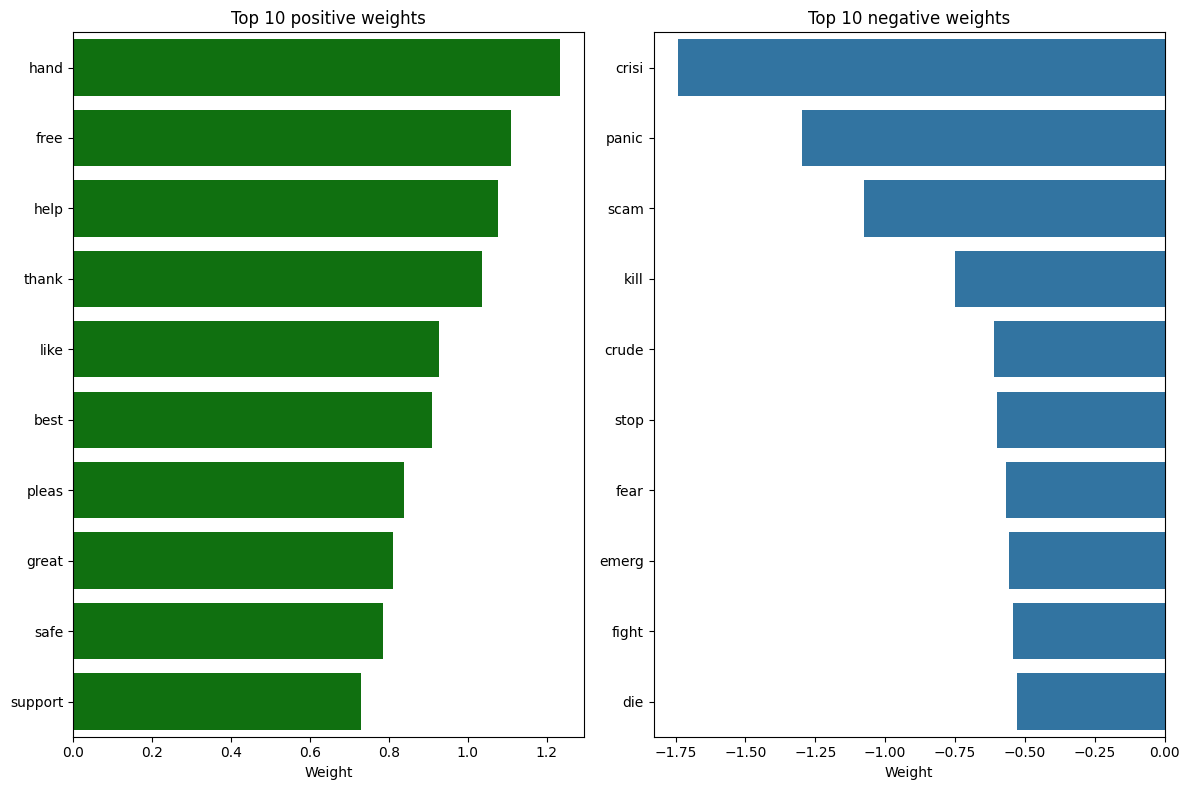

In [105]:
vocab = cv_df.get_feature_names_out()
weights = lr2.coef_[0]

postop = np.argsort(weights)[-10:][::-1]
negtop = np.argsort(weights)[:10]

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=weights[postop], y=vocab[postop], color='green')
plt.title('Top 10 positive weights')
plt.xlabel('Weight')

plt.subplot(1, 2, 2)
sns.barplot(x=weights[negtop], y=vocab[negtop])
plt.title('Top 10 negative weights')
plt.xlabel('Weight')

plt.tight_layout()
plt.show()

**Ответ:** По графику можно сделать вывод, что веса токенов отражают эмоциональную окраску токенов: положительные веса присущи "положительным" токенам (`hand`, `thank`, `free`, `support` и т.д.), негативные веса наблюдаются у "негативных" токенов (`crisi`, `panic`, `kill`, `fear` и т.д.)

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [106]:
# -- YOUR CODE HERE --
df['UserName'].unique()

array([ 3800,  3801,  3802, ..., 44952, 44953, 44955])

In [157]:
df['UserName'].count(), df['UserName'].nunique()

(np.int64(33444), 33444)

In [112]:
df['ScreenName'].unique()

array([48752, 48753, 48754, ..., 89904, 89905, 89907])

In [158]:
df['ScreenName'].count(), df['ScreenName'].nunique()

(np.int64(33444), 33444)

**Ответ:** Данные признаки неполезны, так как они содержат уникальные значения, которые обозначают авторов твиттов. Эта информация не поможет определить эмоциональную окраску твитта

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [140]:
# -- YOUR CODE HERE --
train['TweetAt'].head(5)

,TweetAt
25621,06-04-2020
30135,10-04-2020
28899,09-04-2020
5989,19-03-2020
4367,18-03-2020


In [141]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
train['TweetAt'].head(5)

,TweetAt
25621,2020-04-06
30135,2020-04-10
28899,2020-04-09
5989,2020-03-19
4367,2020-03-18


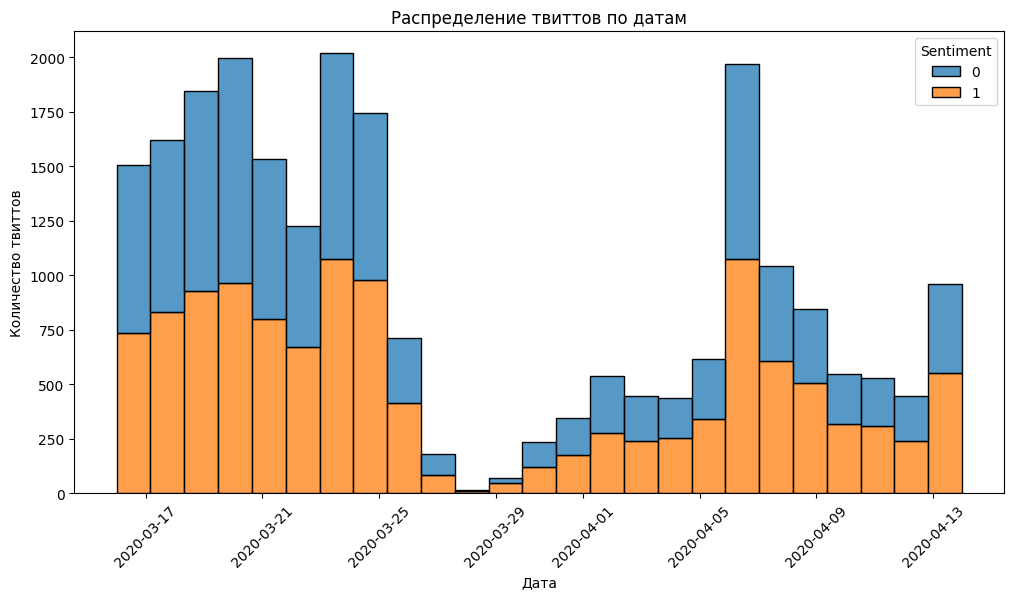

In [161]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', multiple='stack')
plt.xticks(rotation=45)
plt.title('Распределение твиттов по датам')
plt.xlabel('Дата')
plt.ylabel('Количество твиттов')
plt.show()

In [148]:
train['dayofweek'] = train['TweetAt'].dt.dayofweek
train['day'] = train['TweetAt'].dt.day
train['month'] = train['TweetAt'].dt.month

test['TweetAt'] = pd.to_datetime(test['TweetAt'], format='%d-%m-%Y')
test['dayofweek'] = test['TweetAt'].dt.dayofweek
test['day'] = test['TweetAt'].dt.day
test['month'] = test['TweetAt'].dt.month

In [149]:
from scipy.sparse import hstack, csr_matrix
col = ['dayofweek', 'day', 'month']
X_train_new = hstack([X_train_scal, csr_matrix(train[col])])
X_test_new = hstack([X_test_scal, csr_matrix(test[col])])

In [185]:
lr_new = LogisticRegression(random_state=0)
lr_new.fit(X_train_new, y_train)

y_train_pred_new = lr_new.predict(X_train_new)
y_test_pred_new = lr_new.predict(X_test_new)

train_acc_new = accuracy_score(y_train, y_train_pred_new)
test_acc_new = accuracy_score(y_test, y_test_pred_new)

print('доля правильных ответов:')
print('train:', round(train_acc_new, 4))
print('test:', round(test_acc_new, 4))

доля правильных ответов:
train: 0.9413
test: 0.8451


**Ответ:** В определенные дни преобладает определенная эмоциональная окраска твиттов, поэтому этот признак важен. Обучим модель, добавив новые признаки. Год не будем добавлять, так как он везде одинаковый. В результате добавления новых признаков совсем неменого увеличилось качество на тесте


Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [154]:
# -- YOUR CODE HERE --
train['Location'].nunique()

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

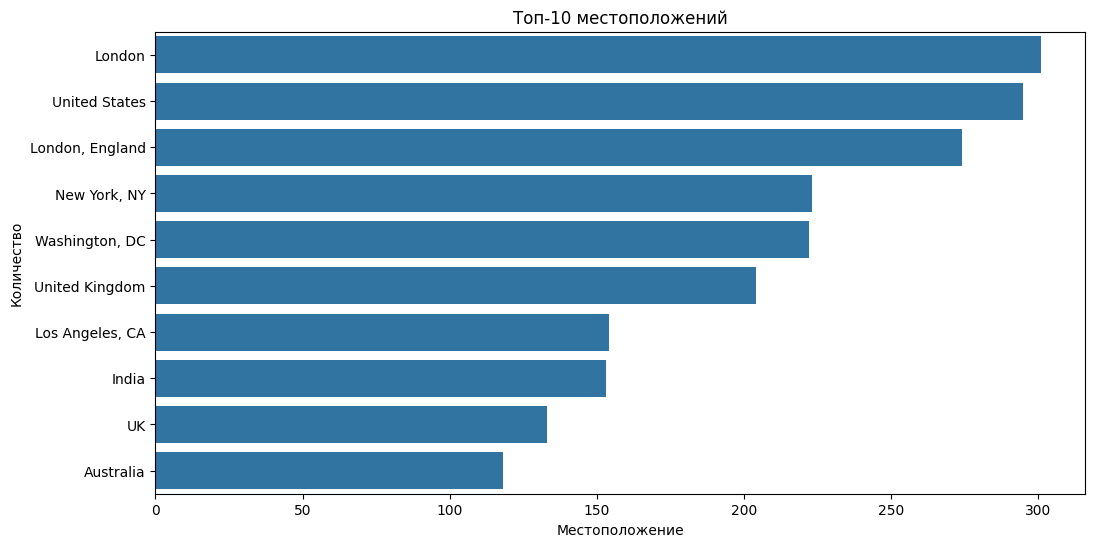

In [165]:
# -- YOUR CODE HERE --
loc = train[train['Location'] != 'Unknown']['Location']
toploc = loc.value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=toploc.values, y=toploc.index)

plt.title('Топ-10 местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество')

plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [164]:
# -- YOUR CODE HERE --
def widerlocation(loc):
  if ',' in loc:
    return loc.split(',')[-1].strip()
  return loc

In [167]:
train['WiderLocation'] = train['Location'].apply(widerlocation)
train['WiderLocation'].nunique()

4766

Количество уникальных категорий уменьшилось

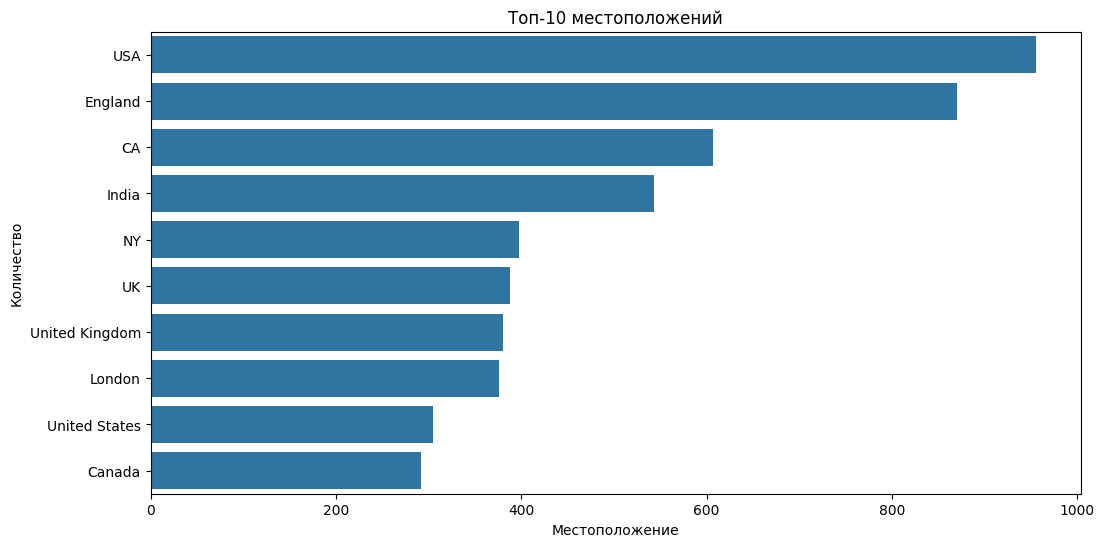

In [169]:
loc = train[train['WiderLocation'] != 'Unknown']['WiderLocation']
toploc = loc.value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=toploc.values, y=toploc.index)

plt.title('Топ-10 местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество')

plt.show()

Теперь в топ10 местоположений входят "широкие" местоположения

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [178]:
# -- YOUR CODE HERE --
from sklearn.preprocessing import OneHotEncoder

test['WiderLocation'] = test['Location'].apply(widerlocation)

ohe = OneHotEncoder(min_frequency=2, handle_unknown='ignore')
ohe_train = ohe.fit_transform(train[['WiderLocation']])
ohe_test = ohe.transform(test[['WiderLocation']])

In [179]:
ohe_train.shape[1]

1006

Теперь 1006 уникальных значений

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [182]:
# -- YOUR CODE HERE --
X_train_3 = hstack([X_train_scal, ohe_train])
X_test_3 = hstack([X_test_scal, ohe_test])

In [184]:
lr_3 = LogisticRegression(random_state=0)
lr_3.fit(X_train_3, y_train)

y_train_pred_3= lr_3.predict(X_train_3)
y_test_pred_3 = lr_3.predict(X_test_3)

train_acc_3 = accuracy_score(y_train, y_train_pred_3)
test_acc_3 = accuracy_score(y_test, y_test_pred_3)

print('доля правильных ответов:')
print('train:', round(train_acc_3, 4))
print('test:', round(test_acc_3, 4))

доля правильных ответов:
train: 0.9448
test: 0.8445


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** На обучающей и тестовой выборках качество немного увеличилось по сравнению с моделью, где не использовалось местоположение в качестве признака